### 1) Import Necessary Libraries

* we start by importing the necessary libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

### 2) Loading and Preparing Dataset

* next we import and process the dataset for the neural network:
    * we convert our target variable to binary numerical representation (this is not strictly necessary)
    * we split our dataset into train and test set
    * we convert our data to tensors
    * finally, we create a dataloader to send our data to the model
    

In [2]:
# import dataset
loan_data = pd.read_csv('preprocessed_loans50k.csv')

# Convert 'status' to numerical labels
status_mapping = {
    'Safe': 0,
    'Risky': 1
}

loan_data['status'] = loan_data['status'].map(status_mapping)

# Separate features and labels
X = loan_data.drop('status', axis=1)
y = loan_data['status']

# Use LabelEncoder to encode 'Safe' as 0 and 'Risky' as 1
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert data to PyTorch tensors
X_train = torch.tensor(X_train.values, dtype=torch.float32)
X_test = torch.tensor(X_test.values, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)

# Create DataLoader for training and testing data
train_dataset = data.TensorDataset(X_train, y_train)
test_dataset = data.TensorDataset(X_test, y_test)

train_loader = data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = data.DataLoader(test_dataset, batch_size=64, shuffle=False)


### 3) Defining Binary Classification Model

In [3]:
class LoanBinaryModel(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(LoanBinaryModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim) # input_dim = 35
        self.relu = nn.ReLU() # activation function
        self.fc2 = nn.Linear(hidden_dim, hidden_dim) # hidden_dim = hyperparameter
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, 1)
        self.sigmoid = nn.Sigmoid() # activation function

    def forward(self, x):
        out = self.fc1(x) 
        out = self.relu(out) 
        out = self.fc2(out)
        out = self.relu(out)
        out = self.fc3(out)
        out = self.relu(out)
        out = self.fc4(out)
        out = self.sigmoid(out)
        return out

### 4) Training Binary Classification Model

In [4]:

from torch.utils.tensorboard import SummaryWriter


def train_binary_model(model, train_loader, test_loader, num_epochs, learning_rate, target_accuracy, device):
    model.to(device)
    criterion = nn.BCELoss()
    optimizer = optim.Adadelta(model.parameters(), lr=learning_rate)
    writer = SummaryWriter()

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for _, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device).view(-1, 1)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels.float())
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        average_loss = total_loss / len(train_loader)
        writer.add_scalar('Loss/train', average_loss, epoch + 1)

        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device).view(-1, 1)
                outputs = model(inputs)
                predicted = (outputs >= 0.5).float()
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / total
        writer.add_scalar('Accuracy/test', accuracy, epoch + 1)

        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {average_loss:.4f}, Accuracy: {accuracy:.2f}%')

        if accuracy >= target_accuracy:
            print(f"Reached target accuracy of {target_accuracy:.2f}%.")
            break

    writer.flush()
    writer.close()

# Set the device to GPU if available, otherwise CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define the model
input_dim = X_train.shape[1]
hidden_dim = 16
model = LoanBinaryModel(input_dim, hidden_dim)

# Train the model with stopping criterion
num_epochs = 100
learning_rate = 0.1
target_accuracy = 95.0  # Stop training when the accuracy reaches 95%
train_binary_model(model, train_loader, test_loader, num_epochs, learning_rate, target_accuracy, device)

Epoch [1/100], Loss: 11.0013, Accuracy: 84.77%
Epoch [2/100], Loss: 8.6628, Accuracy: 85.37%
Epoch [3/100], Loss: 7.5943, Accuracy: 86.63%
Epoch [4/100], Loss: 6.3193, Accuracy: 68.63%
Epoch [5/100], Loss: 5.4615, Accuracy: 87.66%
Epoch [6/100], Loss: 4.8770, Accuracy: 79.63%
Epoch [7/100], Loss: 4.4722, Accuracy: 86.98%
Epoch [8/100], Loss: 4.3837, Accuracy: 88.52%
Epoch [9/100], Loss: 4.1647, Accuracy: 81.98%
Epoch [10/100], Loss: 4.1301, Accuracy: 88.99%
Epoch [11/100], Loss: 4.0001, Accuracy: 84.13%
Epoch [12/100], Loss: 3.7677, Accuracy: 89.43%
Epoch [13/100], Loss: 3.6855, Accuracy: 90.06%
Epoch [14/100], Loss: 3.3345, Accuracy: 86.56%
Epoch [15/100], Loss: 3.3155, Accuracy: 89.18%
Epoch [16/100], Loss: 3.2063, Accuracy: 87.05%
Epoch [17/100], Loss: 3.2207, Accuracy: 89.61%
Epoch [18/100], Loss: 2.9014, Accuracy: 88.01%
Epoch [19/100], Loss: 2.8889, Accuracy: 90.08%
Epoch [20/100], Loss: 2.8746, Accuracy: 90.27%
Epoch [21/100], Loss: 2.4942, Accuracy: 90.47%
Epoch [22/100], Loss:

### 5) Confusion Matrix

Confusion Matrix:
[[7749   17]
 [ 735  842]]

Classification Report:
              precision    recall  f1-score   support

        Safe       0.91      1.00      0.95      7766
       Risky       0.98      0.53      0.69      1577

    accuracy                           0.92      9343
   macro avg       0.95      0.77      0.82      9343
weighted avg       0.92      0.92      0.91      9343



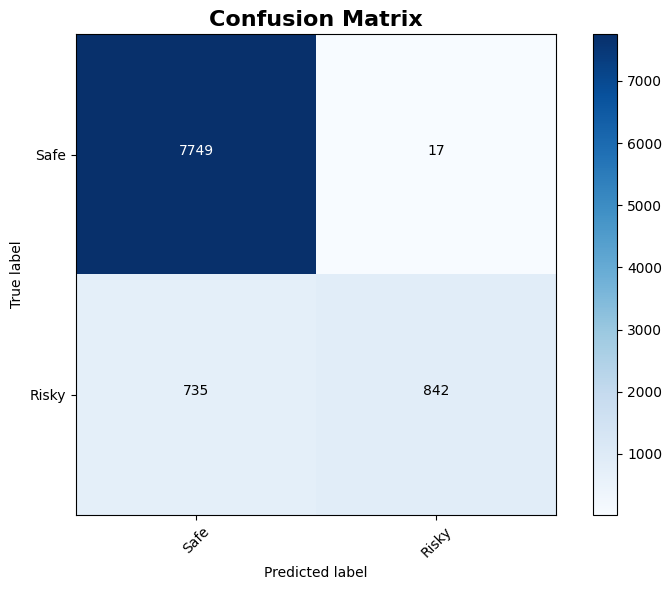

In [5]:
from sklearn.metrics import confusion_matrix, classification_report

def evaluate_model(model, test_loader, device):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device).view(-1, 1)
            outputs = model(inputs)
            predicted = (outputs >= 0.5).float()  # Convert probabilities to binary predictions
            y_pred.extend(predicted.cpu().numpy())
            y_true.extend(labels.cpu().numpy())

    # Convert lists to numpy arrays
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Create the confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    print("Confusion Matrix:")
    print(cm)

    # Print classification report with zero_division parameter
    report = classification_report(y_true, y_pred, target_names=['Safe', 'Risky'], zero_division=1)
    print("\nClassification Report:")
    print(report)

    # Plot the confusion matrix
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion Matrix", fontsize=16, weight='bold')
    plt.colorbar()
    tick_marks = np.arange(len(['Safe', 'Risky']))
    plt.xticks(tick_marks, ['Safe', 'Risky'], rotation=45)
    plt.yticks(tick_marks, ['Safe', 'Risky'])

    # Display the values in each cell
    thresh = cm.max() / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                    horizontalalignment="center",
                    color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

    plt.show()



# Evaluate the trained model and print the confusion matrix
evaluate_model(model, test_loader, device)

### 6) Saving Model

In [6]:
# Save the model's state_dict
from pathlib import Path # to create directory to save model

MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, # create parent directories if needed
                 exist_ok=True # if models directory already exists, don't error
)

MODEL_NAME = "loan_binary_model_state_dict.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

torch.save(model.state_dict(), MODEL_SAVE_PATH) # save model's weights and biases
print(f"Model's state_dict saved to: {MODEL_SAVE_PATH}") 


Model's state_dict saved to: models\loan_binary_model_state_dict.pth


### 6.5) Evaluating the saved Model

In [7]:
# Create an instance of LoanBinaryModel (assumes the same architecture)
loaded_model = LoanBinaryModel(input_dim, hidden_dim)

# Load the saved state_dict
loaded_model.load_state_dict(torch.load(MODEL_SAVE_PATH))

# Send the loaded model to the same device (GPU or CPU)
loaded_model.to(device)

# Set the model to evaluation mode
loaded_model.eval()

# Evaluate the loaded model
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device).view(-1, 1)
        outputs = loaded_model(inputs)
        predicted = (outputs >= 0.5).float()
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Accuracy of the loaded model's weights: {accuracy:.2f}%")

Accuracy of the loaded model's weights: 91.95%


### hyperparameter tuning

* below is the code block that I used to perform hyperparameter tuning to find the best performing params

In [ ]:
from torch.utils.tensorboard import SummaryWriter

def train_binary_model_with_tuning(model, train_loader, test_loader, num_epochs, learning_rate, hidden_dim, optimizer_name, device):
    model.to(device)
    criterion = nn.BCELoss()
    optimizer = get_optimizer(optimizer_name, model.parameters(), lr=learning_rate)
    writer = SummaryWriter(comment=f'-lr_{learning_rate}-hidden_dim_{hidden_dim}-optimizer_{optimizer_name}')

    total_steps = len(train_loader)
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for _, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device).view(-1, 1)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels.float())
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        average_loss = total_loss / len(train_loader)
        writer.add_scalar('Loss/train', average_loss, epoch + 1)

        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device).view(-1, 1)
                outputs = model(inputs)
                predicted = (outputs >= 0.5).float()
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / total
        writer.add_scalar('Accuracy/test', accuracy, epoch + 1)

        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {average_loss:.4f}, Accuracy: {accuracy:.2f}%')

    writer.flush()
    writer.close()

def get_optimizer(optimizer_name, parameters, lr):
    if optimizer_name == 'sgd':
        return optim.SGD(parameters, lr=lr)
    elif optimizer_name == 'adam':
        return optim.Adam(parameters, lr=lr)
    elif optimizer_name == 'adadelta':
        return optim.Adadelta(parameters, lr=lr)
    elif optimizer_name == 'rmsprop':
        return optim.RMSprop(parameters, lr=lr)
    else:
        raise ValueError(f'Optimizer {optimizer_name} not supported.')

# Hyperparameter tuning

# Define hyperparameter search space
learning_rates = [0.1, 0.01, 0.001, 0.0001]
hidden_dims = [16, 32, 64, 128]
optimizers = ['sgd', 'adam', 'adadelta', 'rmsprop']

# Perform grid search over the hyperparameter space
for lr in learning_rates:
    for hidden_dim in hidden_dims:
        for optimizer_name in optimizers:
            model = LoanBinaryModel(input_dim, hidden_dim)
            train_binary_model_with_tuning(model, train_loader, test_loader, num_epochs, lr, hidden_dim, optimizer_name, device)